# Add continuous ranked probability score

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from properscoring import crps_ensemble, crps_gaussian
from scipy.stats import norm

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

In [2]:
training_cells = pd.read_csv("../Data_preprocessing/training.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_in_cells = pd.read_csv("../Data_preprocessing/test_in.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_out_cells = pd.read_csv("../Data_preprocessing/test_out.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()

num_training_cells = len(training_cells)
num_test_in_cells = len(test_in_cells)
num_test_out_cells = len(test_out_cells)

N_train = np.loadtxt("Processed_input_output/N_train.csv",delimiter=",")
N_test_in = np.loadtxt("Processed_input_output/N_test_in.csv",delimiter=",")
N_test_out = np.loadtxt("Processed_input_output/N_test_out.csv",delimiter=",")


a = np.loadtxt('../Empirical_model_fitting/Empirical_parameters_global_train_py.csv').item()

q_true = np.linspace(1,0.8,21)

Q_train_true = np.array([q_true]*num_training_cells)*100
Q_test_in_true = np.array([q_true]*num_test_in_cells)*100
Q_test_out_true = np.array([q_true]*num_test_out_cells)*100


In [13]:
def calculate_confidence_intervals(Q_hat_combined, Q_true, std_combined, num_cells):
    K_c = 11
    c_all = np.linspace(0, 1, K_c)
    c_all[0] = 0.01
    c_all[-1] = 0.99

    z_all = norm.ppf((1 + c_all) / 2)  # Calculate z values for two-sided intervals
    ind = np.zeros((K_c, num_cells, 21))  # To store boolean results
    c_hat = np.zeros(K_c)  # Store observed confidence levels

    for j in range(K_c):
        z = z_all[j]
        ind[j, :] = (Q_true >= Q_hat_combined - z * std_combined) & (Q_true <= Q_hat_combined + z * std_combined)
        c_hat[j] = np.sum(ind[j, :]) / (num_cells * 21)

    ECE = np.mean(np.abs(c_hat - c_all))
    return c_hat, ECE

def negative_log_likelihood(predicted_means, predicted_stds, targets):
    """
    Calculate the negative log-likelihood (NLL) for a set of probabilistic predictions
    assuming a normal distribution for each prediction.
    
    Parameters:
    - predicted_means: Array of predicted means (mu) from the model
    - predicted_stds: Array of predicted standard deviations (sigma) from the model
    - targets: Array of true target values (y)
    
    Returns:
    - nll: Negative log-likelihood value for the dataset
    """
    # Ensure no zero or negative standard deviations (to avoid log(0) or divide by zero)
    if np.any(predicted_stds <= 0):
        raise ValueError("Standard deviations must be positive.")

    # Calculate the negative log-likelihood for each data point
    nll = (0.5 * np.log(2 * np.pi * predicted_stds**2) + 
           ((targets - predicted_means)**2) / (2 * predicted_stds**2))
    
    # Return the mean of NLL for all samples
    return np.mean(nll)

def crps_calc(pred_means, pred_stds, true_vals):
    """
    Calculate the Continuous Ranked Probability Score (CRPS) for a set of probabilistic predictions
    assuming a normal distribution for each prediction.
    
    Parameters:
    - pred_means: Array of predicted means (mu) from the model
    - pred_stds: Array of predicted standard deviations (sigma) from the model
    - true_vals: Array of true target values (y)
    
    Returns:
    - crps: CRPS value for the dataset
    """
    # Ensure no zero or negative standard deviations (to avoid log(0) or divide by zero)
    if np.any(pred_stds <= 0):
        raise ValueError("Standard deviations must be positive.")
    
    # Calculate the CRPS for each data point
    pred_means_flat = pred_means.flatten()
    pred_stds_flat = pred_stds.flatten()
    true_vals_flat = true_vals.flatten()

    crps = np.zeros_like(true_vals_flat)
    for i in range(len(true_vals_flat)):
        crps[i] = crps_gaussian(true_vals_flat[i], pred_means_flat[i], pred_stds_flat[i])    
    # Return the mean of CRPS for all samples
    return np.mean(crps)

Load results from 1 model

In [ ]:
with open('Empirical_parameter_results/E2E_NNE_V2/Q_train_pred_1.pkl', 'rb') as f:
    Q_train_1 = pickle.load(f)
with open('Empirical_parameter_results/E2E_NNE_V2/cov_train_pred_1.pkl', 'rb') as f:
    cov_train_1 = pickle.load(f)

with open('Empirical_parameter_results/E2E_NNE_V2/Q_test_in_pred_1.pkl', 'rb') as f:
    Q_test_in_1 = pickle.load(f)
with open('Empirical_parameter_results/E2E_NNE_V2/cov_test_in_pred_1.pkl', 'rb') as f:
    cov_test_in_1 = pickle.load(f)

with open('Empirical_parameter_results/E2E_NNE_V2/Q_test_out_pred_1.pkl', 'rb') as f:
    Q_test_out_1 = pickle.load(f)
with open('Empirical_parameter_results/E2E_NNE_V2/cov_test_out_pred_1.pkl', 'rb') as f:
    cov_test_out_1 = pickle.load(f)


In [15]:
MAE_train_1 = []
MAE_test_in_1 = []
MAE_test_out_1 = []

NLL_train_1 = []
NLL_test_in_1 = []
NLL_test_out_1 = []

ECE_train_1 = []
ECE_test_in_1 = []
ECE_test_out_1 = []

cali_train_1 = []
cali_test_in_1 = []
cali_test_out_1 = []

crps_train_1 = []
crps_test_in_1 = []
crps_test_out_1 = []

for fold in range(10):
    Q_pred_train_fold = Q_train_1[fold]*100
    cov_train_fold = cov_train_1[fold]
    std_train_fold = np.repeat(cov_train_fold[:, np.newaxis], 
                               Q_pred_train_fold.shape[1], 
                               axis=1)*(100-Q_pred_train_fold)

    MAE_train_1.append(mean_absolute_error(Q_train_true, Q_pred_train_fold))
    NLL_train_1.append(negative_log_likelihood(Q_pred_train_fold, std_train_fold+1e-9, Q_train_true))

    c_hat_train, ECE_train = calculate_confidence_intervals(Q_pred_train_fold, Q_train_true, std_train_fold, num_training_cells)
    ECE_train_1.append(ECE_train)
    cali_train_1.append(c_hat_train)
    crps_train_1.append(crps_calc(Q_pred_train_fold, std_train_fold+1e-9, Q_train_true))

    Q_pred_test_in_fold = Q_test_in_1[fold]*100
    cov_test_in_fold = cov_test_in_1[fold]
    std_test_in_fold = np.repeat(cov_test_in_fold[:, np.newaxis], 
                               Q_pred_test_in_fold.shape[1], 
                               axis=1)*(100-Q_pred_test_in_fold)

    MAE_test_in_1.append(mean_absolute_error(Q_test_in_true, Q_pred_test_in_fold))
    NLL_test_in_1.append(negative_log_likelihood(Q_pred_test_in_fold, std_test_in_fold+1e-9, Q_test_in_true))

    c_hat_test_in, ECE_test_in = calculate_confidence_intervals(Q_pred_test_in_fold, Q_test_in_true, std_test_in_fold+1e-9, num_test_in_cells)
    ECE_test_in_1.append(ECE_test_in)
    cali_test_in_1.append(c_hat_test_in)
    crps_test_in_1.append(crps_calc(Q_pred_test_in_fold, std_test_in_fold+1e-9, Q_test_in_true))

    Q_pred_test_out_fold = Q_test_out_1[fold]*100
    cov_test_out_fold = cov_test_out_1[fold]
    std_test_out_fold = np.repeat(cov_test_out_fold[:, np.newaxis], 
                               Q_pred_test_out_fold.shape[1], 
                               axis=1)*(100-Q_pred_test_out_fold)

    MAE_test_out_1.append(mean_absolute_error(Q_test_out_true, Q_pred_test_out_fold))
    NLL_test_out_1.append(negative_log_likelihood(Q_pred_test_out_fold, std_test_out_fold+1e-9, Q_test_out_true))

    c_hat_test_out, ECE_test_out = calculate_confidence_intervals(Q_pred_test_out_fold, Q_test_out_true, std_test_out_fold+1e-9, num_test_out_cells)
    ECE_test_out_1.append(ECE_test_out)
    cali_test_out_1.append(c_hat_test_out)
    crps_test_out_1.append(crps_calc(Q_pred_test_out_fold, std_test_out_fold+1e-9, Q_test_out_true))




In [16]:
print(f"Mean MAE train 1: {np.mean(MAE_train_1) :.2f}")
print(f"Mean MAE test in 1: {np.mean(MAE_test_in_1) :.2f}")
print(f"Mean MAE test out 1: {np.mean(MAE_test_out_1) :.2f}")

print(f"Mean NLL train 1: {np.mean(NLL_train_1) :.2f}")
print(f"Mean NLL test in 1: {np.mean(NLL_test_in_1) :.2f}")
print(f"Mean NLL test out 1: {np.mean(NLL_test_out_1) :.2e}")

print(f"Mean ECE train 1: {np.mean(ECE_train_1) :.3f}")
print(f"Mean ECE test in 1: {np.mean(ECE_test_in_1) :.3f}")
print(f"Mean ECE test out 1: {np.mean(ECE_test_out_1) :.3f}")

print(f"Mean CRPS train 1: {np.mean(crps_train_1) :.3f}")
print(f"Mean CRPS test in 1: {np.mean(crps_test_in_1) :.3f}")
print(f"Mean CRPS test out 1: {np.mean(crps_test_out_1) :.3f}")

Mean MAE train 1: 1.85
Mean MAE test in 1: 2.43
Mean MAE test out 1: 7.84
Mean NLL train 1: 2.63
Mean NLL test in 1: 3.29
Mean NLL test out 1: 2.57e+13
Mean ECE train 1: 0.058
Mean ECE test in 1: 0.067
Mean ECE test out 1: 0.223
Mean CRPS train 1: 1.459
Mean CRPS test in 1: 1.856
Mean CRPS test out 1: 5.718


Load predictions for ensembles of 5

In [ ]:
with open('Empirical_parameter_results/E2E_NNE_V2/Q_train_pred_5_ensemble.pkl', 'rb') as f:
    Q_train_5 = pickle.load(f)
with open('Empirical_parameter_results/E2E_NNE_V2/std_train_pred_5_ensemble.pkl', 'rb') as f:
    std_train_5 = pickle.load(f)

with open('Empirical_parameter_results/E2E_NNE_V2/Q_test_in_pred_5_ensemble.pkl', 'rb') as f:
    Q_test_in_5 = pickle.load(f)
with open('Empirical_parameter_results/E2E_NNE_V2/std_test_in_pred_5_ensemble.pkl', 'rb') as f:
    std_test_in_5 = pickle.load(f)

with open('Empirical_parameter_results/E2E_NNE_V2/Q_test_out_pred_5_ensemble.pkl', 'rb') as f:
    Q_test_out_5 = pickle.load(f)
with open('Empirical_parameter_results/E2E_NNE_V2/std_test_out_pred_5_ensemble.pkl', 'rb') as f:
    std_test_out_5 = pickle.load(f)

In [18]:
MAE_train_5 = []
MAE_test_in_5 = []
MAE_test_out_5 = []

NLL_train_5 = []
NLL_test_in_5 = []
NLL_test_out_5 = []

ECE_train_5 = []
ECE_test_in_5 = []
ECE_test_out_5 = []

cali_train_5 = []
cali_test_in_5 = []
cali_test_out_5 = []

crps_train_5 = []
crps_test_in_5 = []
crps_test_out_5 = []

for fold in range(10):
    Q_pred_train_fold = Q_train_5[fold]
    std_train_fold = std_train_5[fold]

    MAE_train_5.append(mean_absolute_error(Q_train_true, Q_pred_train_fold))
    NLL_train_5.append(negative_log_likelihood(Q_pred_train_fold, std_train_fold+1e-9, Q_train_true))

    c_hat_train, ECE_train = calculate_confidence_intervals(Q_pred_train_fold, Q_train_true, std_train_fold+1e-9, num_training_cells)
    ECE_train_5.append(ECE_train)
    cali_train_5.append(c_hat_train)
    crps_train_5.append(crps_calc(Q_pred_train_fold, std_train_fold+1e-9, Q_train_true))

    Q_pred_test_in_fold = Q_test_in_5[fold]
    std_test_in_fold = std_test_in_5[fold]

    MAE_test_in_5.append(mean_absolute_error(Q_test_in_true, Q_pred_test_in_fold))
    NLL_test_in_5.append(negative_log_likelihood(Q_pred_test_in_fold, std_test_in_fold+1e-9, Q_test_in_true))

    c_hat_test_in, ECE_test_in = calculate_confidence_intervals(Q_pred_test_in_fold, Q_test_in_true, std_test_in_fold+1e-9, num_test_in_cells)
    ECE_test_in_5.append(ECE_test_in)
    cali_test_in_5.append(c_hat_test_in)
    crps_test_in_5.append(crps_calc(Q_pred_test_in_fold, std_test_in_fold+1e-9, Q_test_in_true))

    Q_pred_test_out_fold = Q_test_out_5[fold]
    std_test_out_fold = std_test_out_5[fold]

    MAE_test_out_5.append(mean_absolute_error(Q_test_out_true, Q_pred_test_out_fold))
    NLL_test_out_5.append(negative_log_likelihood(Q_pred_test_out_fold, std_test_out_fold+1e-9, Q_test_out_true))

    c_hat_test_out, ECE_test_out = calculate_confidence_intervals(Q_pred_test_out_fold, Q_test_out_true, std_test_out_fold+1e-9, num_test_out_cells)
    ECE_test_out_5.append(ECE_test_out)
    cali_test_out_5.append(c_hat_test_out)
    crps_test_out_5.append(crps_calc(Q_pred_test_out_fold, std_test_out_fold+1e-9, Q_test_out_true))


In [19]:
print(f"Mean MAE train 5: {np.mean(MAE_train_5) :.2f}")
print(f"Mean MAE test in 5: {np.mean(MAE_test_in_5) :.2f}")
print(f"Mean MAE test out 5: {np.mean(MAE_test_out_5) :.2f}")

print(f"Mean NLL train 5: {np.mean(NLL_train_5) :.2f}")
print(f"Mean NLL test in 5: {np.mean(NLL_test_in_5) :.2f}")
print(f"Mean NLL test out 5: {np.mean(NLL_test_out_5) :.2f}")

print(f"Mean ECE train 5: {np.mean(ECE_train_5) :.3f}")
print(f"Mean ECE test in 5: {np.mean(ECE_test_in_5) :.3f}")
print(f"Mean ECE test out 5: {np.mean(ECE_test_out_5) :.3f}")

print(f"Mean CRPS train 5: {np.mean(crps_train_5) :.3f}")
print(f"Mean CRPS test in 5: {np.mean(crps_test_in_5) :.3f}")
print(f"Mean CRPS test out 5: {np.mean(crps_test_out_5) :.3f}")

Mean MAE train 5: 1.70
Mean MAE test in 5: 2.00
Mean MAE test out 5: 6.44
Mean NLL train 5: 2.38
Mean NLL test in 5: 2.50
Mean NLL test out 5: 2.94
Mean ECE train 5: 0.100
Mean ECE test in 5: 0.078
Mean ECE test out 5: 0.094
Mean CRPS train 5: 1.411
Mean CRPS test in 5: 1.634
Mean CRPS test out 5: 4.163


Load resutls from ensembles of 10 models

In [ ]:
with open('Empirical_parameter_results/E2E_NNE_V2/Q_train_pred_10_ensemble.pkl', 'rb') as f:
    Q_train_10 = pickle.load(f)
with open('Empirical_parameter_results/E2E_NNE_V2/std_train_pred_10_ensemble.pkl', 'rb') as f:
    std_train_10 = pickle.load(f)

with open('Empirical_parameter_results/E2E_NNE_V2/Q_test_in_pred_10_ensemble.pkl', 'rb') as f:
    Q_test_in_10 = pickle.load(f)
with open('Empirical_parameter_results/E2E_NNE_V2/std_test_in_pred_10_ensemble.pkl', 'rb') as f:
    std_test_in_10 = pickle.load(f)

with open('Empirical_parameter_results/E2E_NNE_V2/Q_test_out_pred_10_ensemble.pkl', 'rb') as f:
    Q_test_out_10 = pickle.load(f)
with open('Empirical_parameter_results/E2E_NNE_V2/std_test_out_pred_10_ensemble.pkl', 'rb') as f:
    std_test_out_10 = pickle.load(f)

In [21]:
MAE_train_10 = []
MAE_test_in_10 = []
MAE_test_out_10 = []

NLL_train_10 = []
NLL_test_in_10 = []
NLL_test_out_10 = []

ECE_train_10 = []
ECE_test_in_10 = []
ECE_test_out_10 = []

cali_train_10 = []
cali_test_in_10 = []
cali_test_out_10 = []

crps_train_10 = []
crps_test_in_10 = []
crps_test_out_10 = []

for fold in range(10):
    Q_pred_train_fold = Q_train_10[fold]
    std_train_fold = std_train_10[fold]

    MAE_train_10.append(mean_absolute_error(Q_train_true, Q_pred_train_fold))
    NLL_train_10.append(negative_log_likelihood(Q_pred_train_fold, std_train_fold+1e-9, Q_train_true))

    c_hat_train, ECE_train = calculate_confidence_intervals(Q_pred_train_fold, Q_train_true, std_train_fold+1e-9, num_training_cells)
    ECE_train_10.append(ECE_train)
    cali_train_10.append(c_hat_train)
    crps_train_10.append(crps_calc(Q_pred_train_fold, std_train_fold+1e-9, Q_train_true))

    Q_pred_test_in_fold = Q_test_in_10[fold]
    std_test_in_fold = std_test_in_10[fold]

    MAE_test_in_10.append(mean_absolute_error(Q_test_in_true, Q_pred_test_in_fold))
    NLL_test_in_10.append(negative_log_likelihood(Q_pred_test_in_fold, std_test_in_fold+1e-9, Q_test_in_true))

    c_hat_test_in, ECE_test_in = calculate_confidence_intervals(Q_pred_test_in_fold, Q_test_in_true, std_test_in_fold+1e-9, num_test_in_cells)
    ECE_test_in_10.append(ECE_test_in)
    cali_test_in_10.append(c_hat_test_in)
    crps_test_in_10.append(crps_calc(Q_pred_test_in_fold, std_test_in_fold+1e-9, Q_test_in_true))

    Q_pred_test_out_fold = Q_test_out_10[fold]
    std_test_out_fold = std_test_out_10[fold]

    MAE_test_out_10.append(mean_absolute_error(Q_test_out_true, Q_pred_test_out_fold))
    NLL_test_out_10.append(negative_log_likelihood(Q_pred_test_out_fold, std_test_out_fold+1e-9, Q_test_out_true))

    c_hat_test_out, ECE_test_out = calculate_confidence_intervals(Q_pred_test_out_fold, Q_test_out_true, std_test_out_fold+1e-9, num_test_out_cells)
    ECE_test_out_10.append(ECE_test_out)
    cali_test_out_10.append(c_hat_test_out)
    crps_test_out_10.append(crps_calc(Q_pred_test_out_fold, std_test_out_fold+1e-9, Q_test_out_true))


In [22]:
print(f"Mean MAE train 10: {np.mean(MAE_train_10) :.2f}")
print(f"Mean MAE test in 10: {np.mean(MAE_test_in_10) :.2f}")
print(f"Mean MAE test out 10: {np.mean(MAE_test_out_10) :.2f}")

print(f"Mean NLL train 10: {np.mean(NLL_train_10) :.2f}")
print(f"Mean NLL test in 10: {np.mean(NLL_test_in_10) :.2f}")
print(f"Mean NLL test out 10: {np.mean(NLL_test_out_10) :.2f}")

print(f"Mean ECE train 10: {np.mean(ECE_train_10) :.3f}")
print(f"Mean ECE test in 10: {np.mean(ECE_test_in_10) :.3f}")
print(f"Mean ECE test out 10: {np.mean(ECE_test_out_10) :.3f}")

print(f"Mean CRPS train 10: {np.mean(crps_train_10) :.3f}")
print(f"Mean CRPS test in 10: {np.mean(crps_test_in_10) :.3f}")
print(f"Mean CRPS test out 10: {np.mean(crps_test_out_10) :.3f}")

Mean MAE train 10: 1.73
Mean MAE test in 10: 2.05
Mean MAE test out 10: 7.14
Mean NLL train 10: 2.41
Mean NLL test in 10: 2.50
Mean NLL test out 10: 3.06
Mean ECE train 10: 0.102
Mean ECE test in 10: 0.077
Mean ECE test out 10: 0.087
Mean CRPS train 10: 1.438
Mean CRPS test in 10: 1.658
Mean CRPS test out 10: 4.645


Create dataframes for boxplots

In [23]:
MAE_plot = []
NLL_plot = []
ECE_plot = []
CRPS_plot = []
model_type = []
data_subset = []

for i in range(10):
    MAE_plot.append(MAE_train_1[i])
    NLL_plot.append(NLL_train_1[i])
    ECE_plot.append(ECE_train_1[i])
    CRPS_plot.append(crps_train_1[i])
    model_type.append('$M = 1$')
    data_subset.append('Training')

    MAE_plot.append(MAE_test_in_1[i])
    NLL_plot.append(NLL_test_in_1[i])
    ECE_plot.append(ECE_test_in_1[i])
    CRPS_plot.append(crps_test_in_1[i])
    model_type.append('$M = 1$')
    data_subset.append('High-DoD\nTest')

    MAE_plot.append(MAE_test_out_1[i])
    NLL_plot.append(NLL_test_out_1[i])
    ECE_plot.append(ECE_test_out_1[i])
    CRPS_plot.append(crps_test_out_1[i])
    model_type.append('$M = 1$')
    data_subset.append('Low-DoD\nTest')


    MAE_plot.append(MAE_train_5[i])
    NLL_plot.append(NLL_train_5[i])
    ECE_plot.append(ECE_train_5[i])
    CRPS_plot.append(crps_train_5[i])
    model_type.append('$M = 5$')
    data_subset.append('Training')

    MAE_plot.append(MAE_test_in_5[i])
    NLL_plot.append(NLL_test_in_5[i])
    ECE_plot.append(ECE_test_in_5[i])
    CRPS_plot.append(crps_test_in_5[i])
    model_type.append('$M = 5$')
    data_subset.append('High-DoD\nTest')

    MAE_plot.append(MAE_test_out_5[i])
    NLL_plot.append(NLL_test_out_5[i])
    ECE_plot.append(ECE_test_out_5[i])
    CRPS_plot.append(crps_test_out_5[i])
    model_type.append('$M = 5$')
    data_subset.append('Low-DoD\nTest')


    MAE_plot.append(MAE_train_10[i])
    NLL_plot.append(NLL_train_10[i])
    ECE_plot.append(ECE_train_10[i])
    CRPS_plot.append(crps_train_10[i])
    model_type.append('$M = 10$')
    data_subset.append('Training')

    MAE_plot.append(MAE_test_in_10[i])
    NLL_plot.append(NLL_test_in_10[i])
    ECE_plot.append(ECE_test_in_10[i])
    CRPS_plot.append(crps_test_in_10[i])
    model_type.append('$M = 10$')
    data_subset.append('High-DoD\nTest')

    MAE_plot.append(MAE_test_out_10[i])
    NLL_plot.append(NLL_test_out_10[i])
    ECE_plot.append(ECE_test_out_10[i])
    CRPS_plot.append(crps_test_out_10[i])
    model_type.append('$M = 10$')
    data_subset.append('Low-DoD\nTest')

MAE_df = pd.DataFrame({'Error': MAE_plot, 'Model Type': model_type, 'Data Subset': data_subset})
NLL_df = pd.DataFrame({'Error': NLL_plot, 'Model Type': model_type, 'Data Subset': data_subset})
ECE_df = pd.DataFrame({'Error': ECE_plot, 'Model Type': model_type, 'Data Subset': data_subset})
CRPS_df = pd.DataFrame({'Error': CRPS_plot, 'Model Type': model_type, 'Data Subset': data_subset})

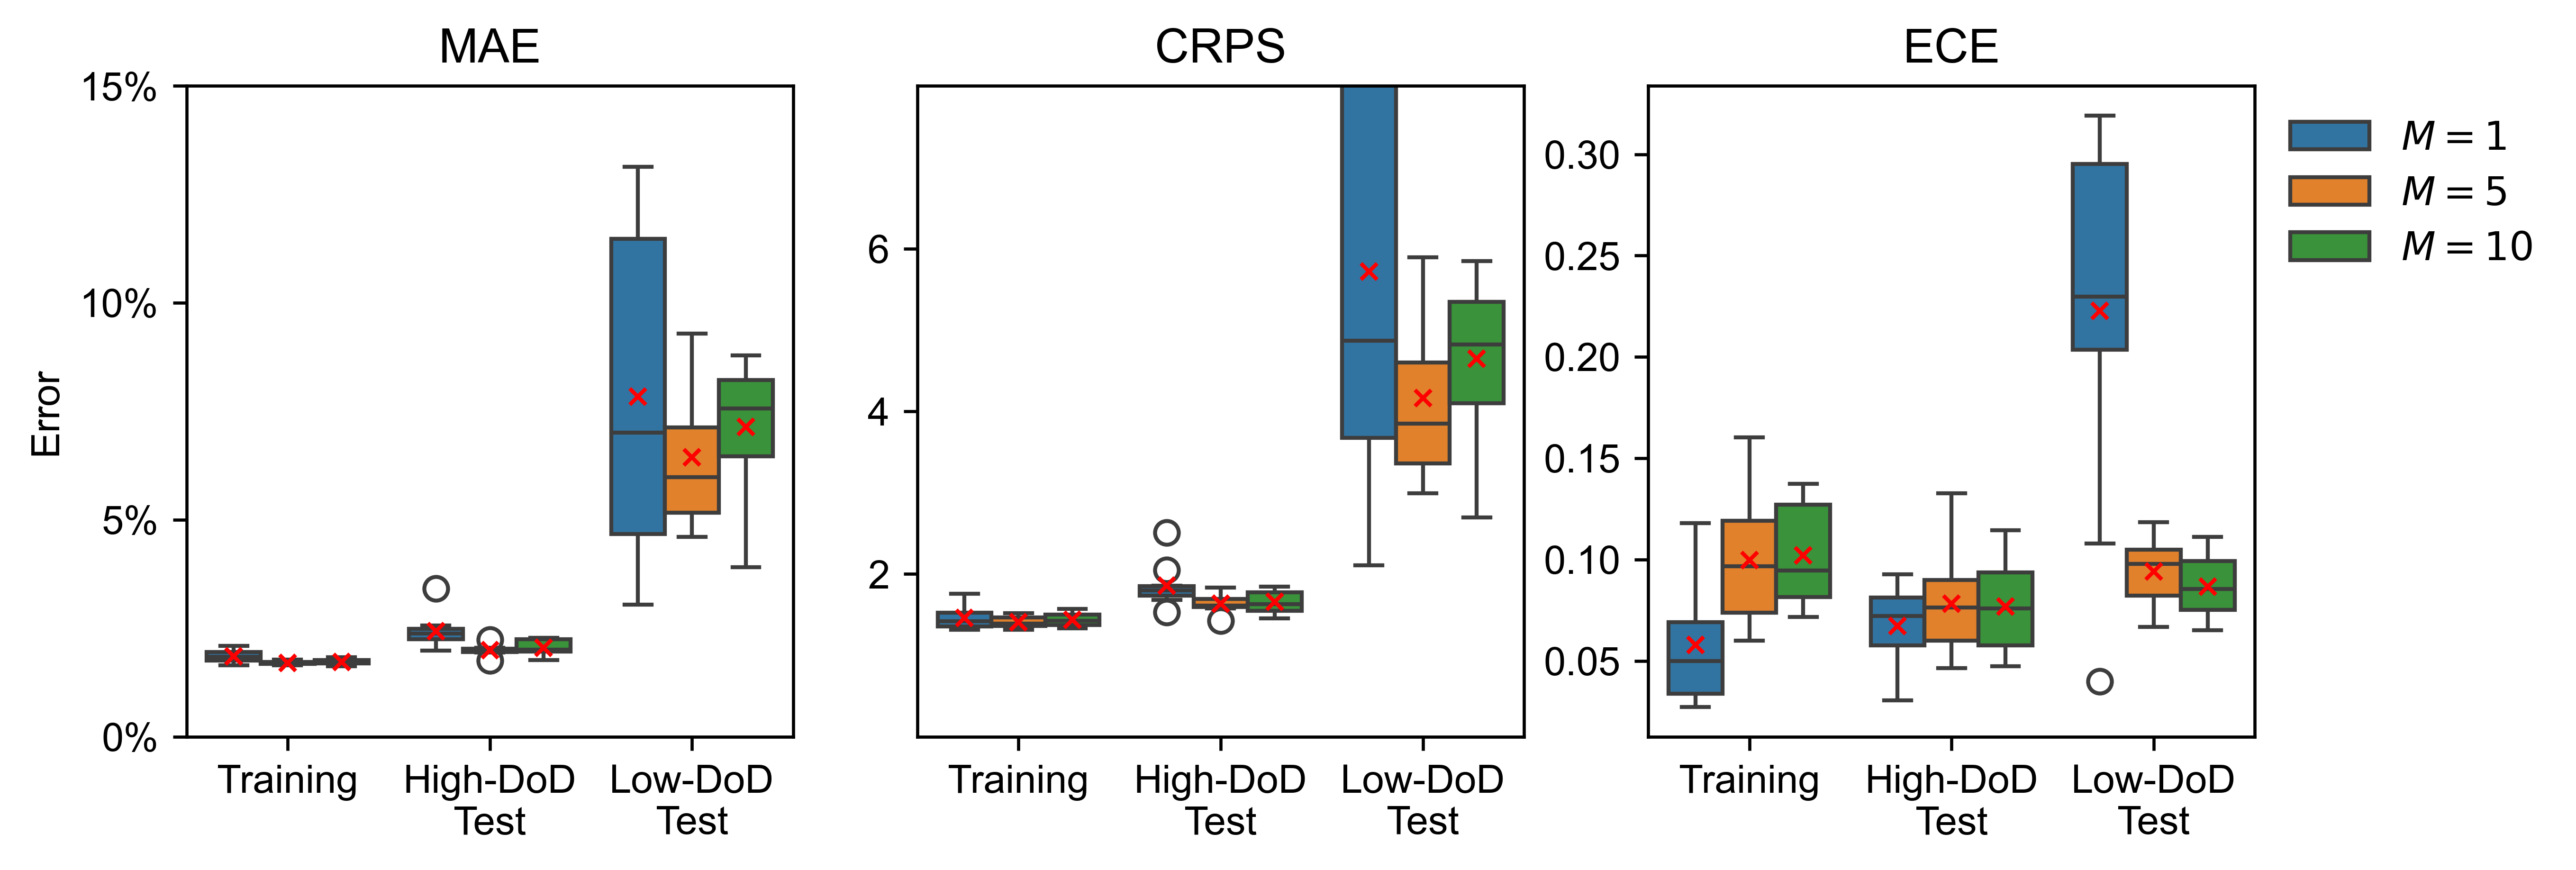

In [ ]:
# fig, ax = plt.subplots(4, 3, figsize=(8, 9))
fig, ax = plt.subplots(1, 3, figsize=(9, 3),dpi=600)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

sns.boxplot(data=MAE_df,x='Data Subset',y='Error',hue='Model Type',ax=ax[0],showmeans=True,
             meanprops={'marker':'x',
                       'markerfacecolor':'red', 
                       'markeredgecolor':'red',
                       'markersize':'4',
                       'label':'Mean'})
ax[0].set_title('MAE')
ax[0].set_ylim(0,15)
ax[0].set_yticks([0,5,10,15])
ax[0].set_yticklabels(['0%','5%','10%','15%'])
ax[0].set_ylabel('Error')
ax[0].set_xlabel(None)
ax[0].legend().set_visible(False)


sns.boxplot(data=CRPS_df,x='Data Subset',y='Error',hue='Model Type',ax=ax[1],showmeans=True,
             meanprops={'marker':'x',
                       'markerfacecolor':'red', 
                       'markeredgecolor':'red',
                       'markersize':'4'})
ax[1].set_title('CRPS')
ax[1].set_ylim(0,8)
ax[1].set_yticks([2,4,6])
# ax[1].set_yticklabels(['0%','2%','4%','6%','8%','10%'])
ax[1].legend().set_visible(False)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)


sns.boxplot(data=ECE_df,x='Data Subset',y='Error',hue='Model Type',ax=ax[2],showmeans=True,
             meanprops={'marker':'x',
                       'markerfacecolor':'red', 
                       'markeredgecolor':'red',
                       'markersize':'4',
                       'label':'Mean'})
ax[2].set_title('ECE')
# ax[2].set_ylim(0,40)
# ax[2].set_yticks([0,10,20,30,40])
# ax[2].set_yticklabels(['0%','10%','20%','30%','40%'])
# ax[2].legend().set_visible(False)
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)
ax[2].legend_.set_title(None)
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend(handles[-3:], labels[-3:],loc=2,bbox_to_anchor=(1, 1),frameon=False)


# for ax_ in ax:
#     ax_.tick_params(axis='x', rotation=40)  # Rotate the labels
#     plt.setp(ax_.get_xticklabels(), ha='right')  # Align the labels to the right

plt.tight_layout(pad=0.5)
plt.show()

# Visualization of the calibration curves

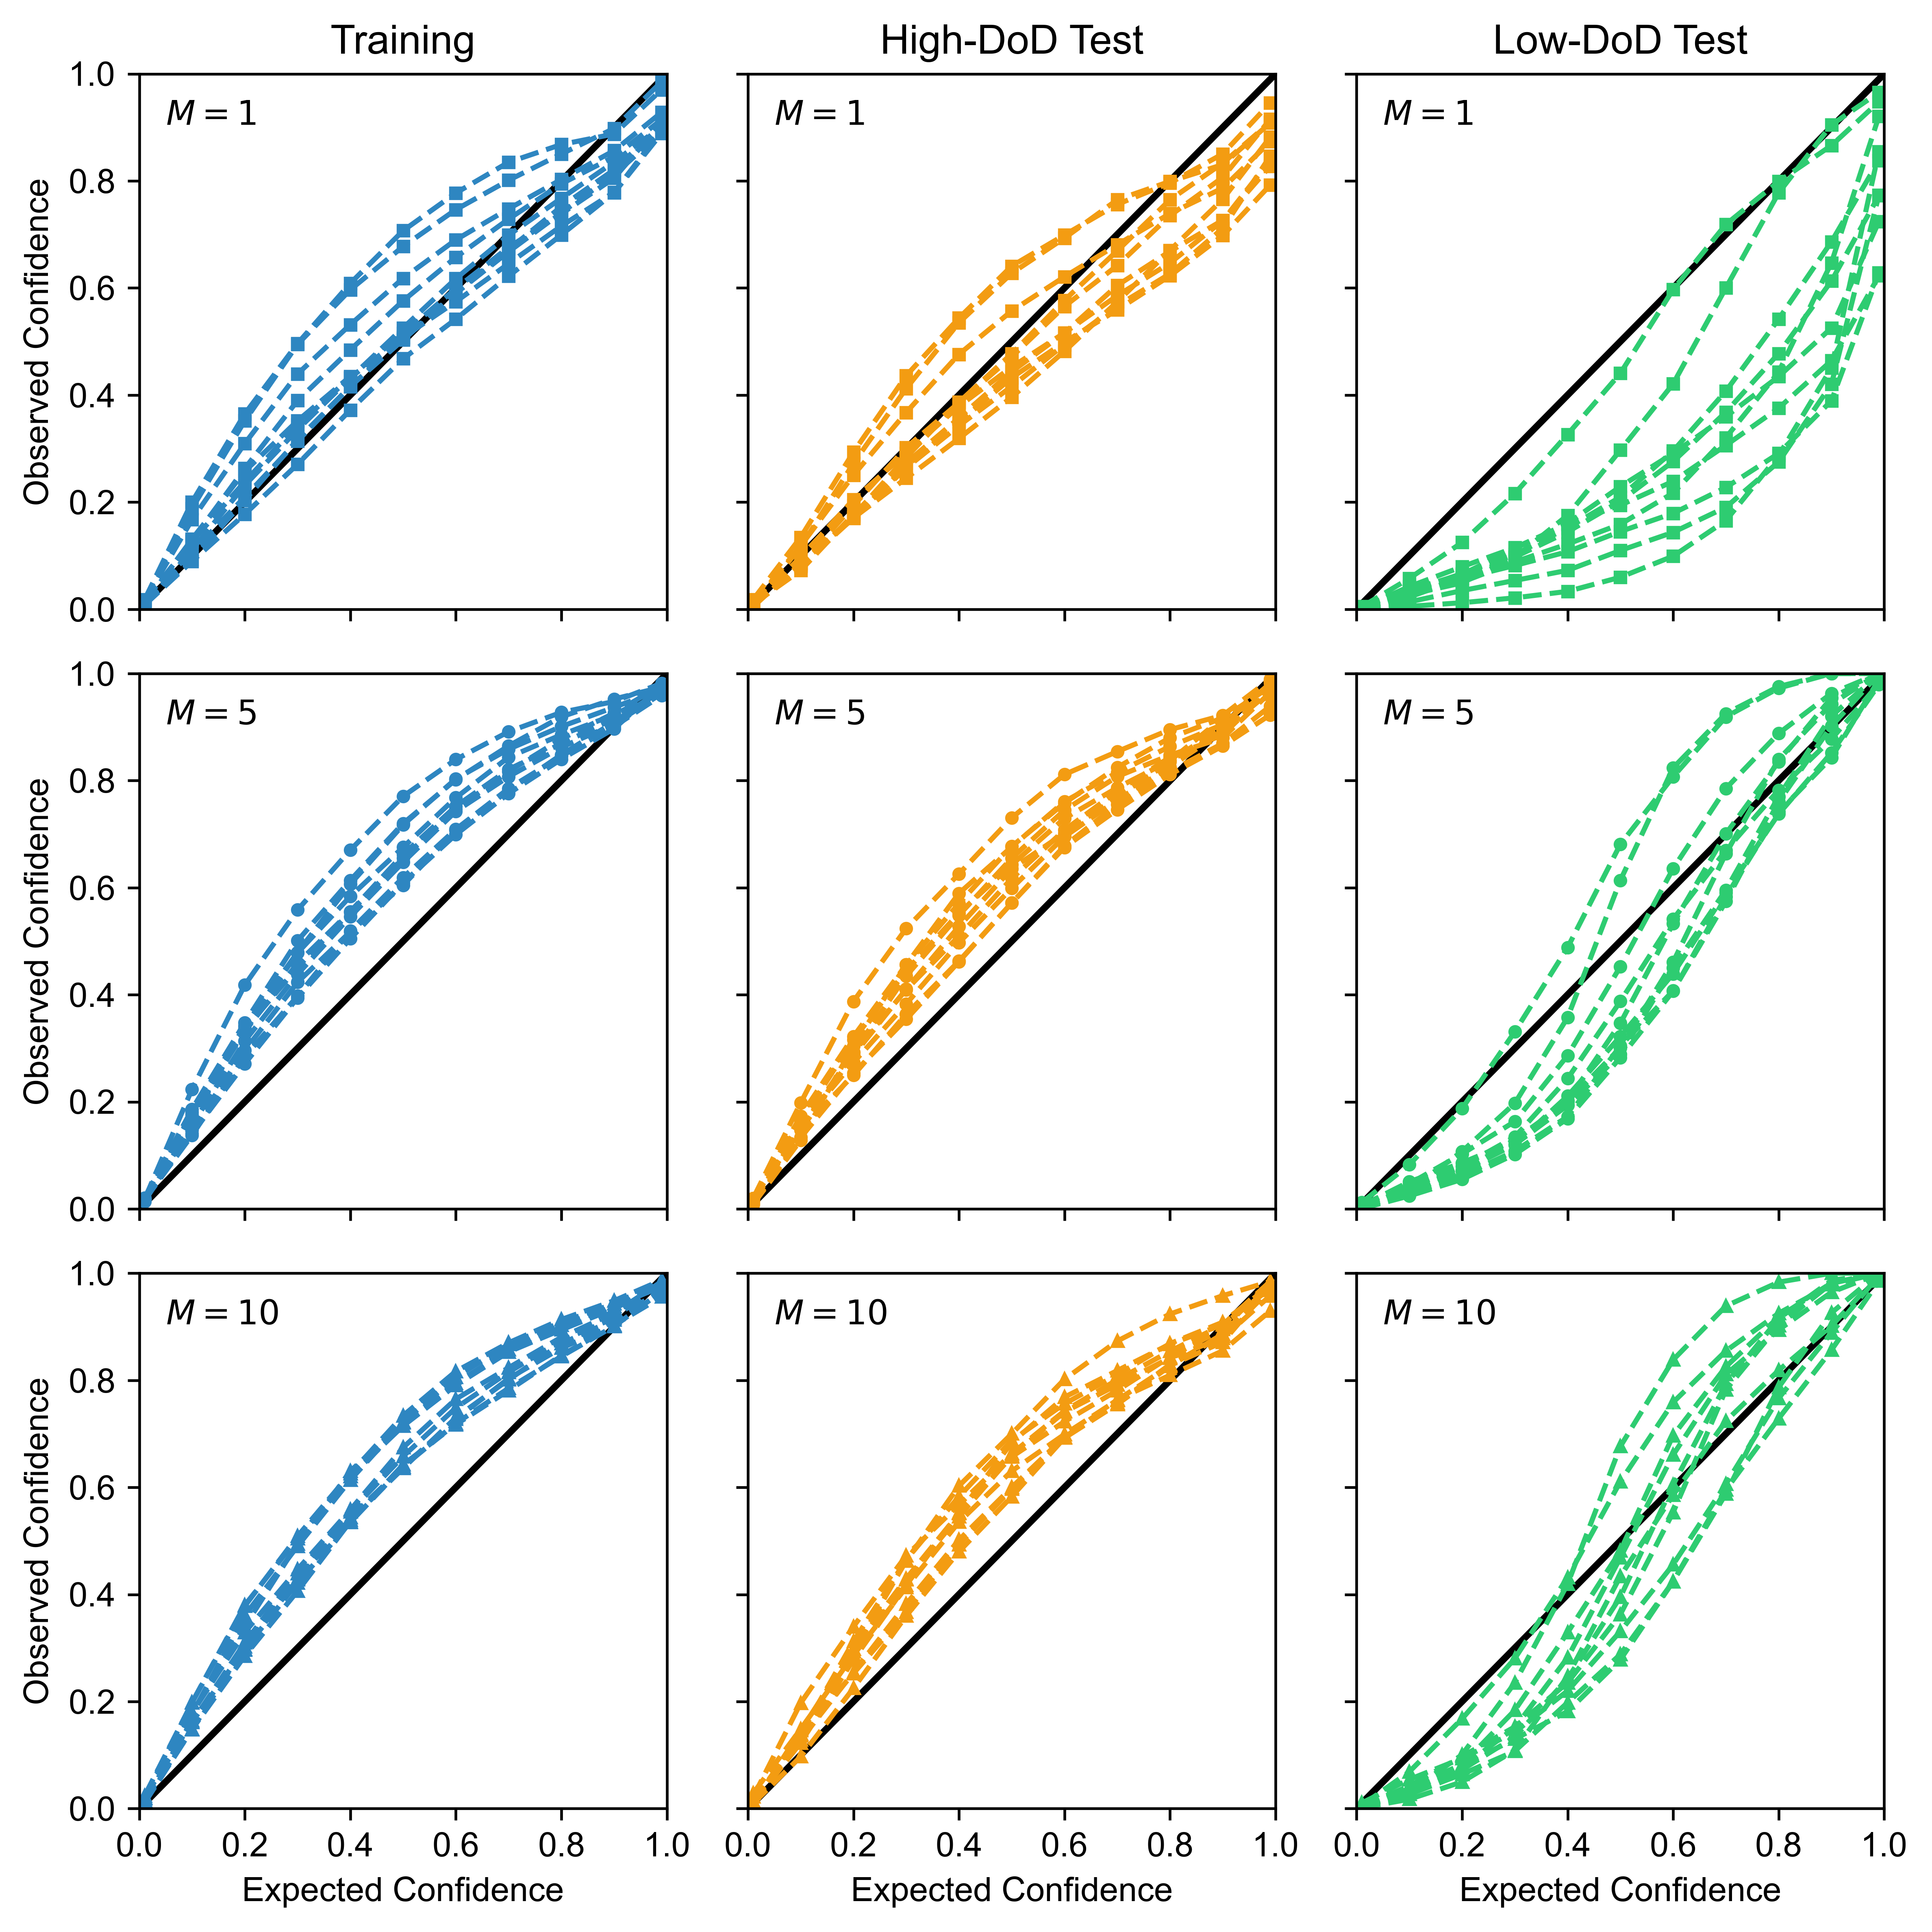

In [ ]:
K_c = 11
c_all = np.linspace(0, 1, K_c)
c_all[0] = 0.01
c_all[-1] = 0.99
colors = ["#2E86C1","#F39C12","#2ECC71",[0.5,0.5,0.5]]

fig, axs = plt.subplots(3, 3, figsize=(8, 8), dpi=600,sharey=True,sharex=True)

nums = [1,5,10]
for i, ax in enumerate(axs.flat):
    ax.text(0.05, 0.95, f'$M = {nums[i//3]}$', transform=ax.transAxes, fontsize=10, verticalalignment='top', backgroundcolor=(1,1,1,0.9))
    ax.plot([0, 1], [0, 1], 'k', linewidth=2)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

for fold in range(10):
    axs[0,0].plot(c_all, cali_train_1[fold], 's--', c=colors[0], markersize=3, linewidth=1.5)
    axs[0,1].plot(c_all, cali_test_in_1[fold], 's--', c=colors[1], markersize=3, linewidth=1.5)
    axs[0,2].plot(c_all, cali_test_out_1[fold], 's--', c=colors[2], markersize=3, linewidth=1.5)

    axs[1,0].plot(c_all, cali_train_5[fold], '.--', c=colors[0], markersize=6, linewidth=1.5)
    axs[1,1].plot(c_all, cali_test_in_5[fold], '.--', c=colors[1], markersize=6, linewidth=1.5)
    axs[1,2].plot(c_all, cali_test_out_5[fold], '.--', c=colors[2], markersize=6, linewidth=1.5)

    axs[2,0].plot(c_all, cali_train_10[fold], '^--', c=colors[0], markersize=3, linewidth=1.5)
    axs[2,1].plot(c_all, cali_test_in_10[fold], '^--', c=colors[1], markersize=3, linewidth=1.5)
    axs[2,2].plot(c_all, cali_test_out_10[fold], '^--', c=colors[2], markersize=3, linewidth=1.5)

axs[0,0].set_title('Training')
axs[0,1].set_title('High-DoD Test')
axs[0,2].set_title('Low-DoD Test')
axs[0,0].set_ylabel('Observed Confidence')
axs[0,0].set_yticks([0,0.2,0.4,0.6,0.8,1])
axs[1,0].set_ylabel('Observed Confidence')
axs[1,0].set_yticks([0,0.2,0.4,0.6,0.8,1])
axs[2,0].set_ylabel('Observed Confidence')
axs[2,0].set_yticks([0,0.2,0.4,0.6,0.8,1])


axs[2,0].set_xlabel('Expected Confidence')
axs[2,0].set_xticks([0,0.2,0.4,0.6,0.8,1])
axs[2,1].set_xlabel('Expected Confidence')
axs[2,1].set_xticks([0,0.2,0.4,0.6,0.8,1])
axs[2,2].set_xlabel('Expected Confidence')
axs[2,2].set_xticks([0,0.2,0.4,0.6,0.8,1])

plt.tight_layout(pad=1)
plt.show()

In [ ]:
# Save Df for M = 5 for benchmark study
MAE_df_5 = MAE_df[MAE_df['Model Type'] == '$M = 5$']
NLL_df_5 = NLL_df[NLL_df['Model Type'] == '$M = 5$']
ECE_df_5 = ECE_df[ECE_df['Model Type'] == '$M = 5$']
CRPS_df_5 = CRPS_df[CRPS_df['Model Type'] == '$M = 5$']

MAE_df_5.to_csv('../Case_study_LSTM_ensemble/MAE_df_e2e.csv',index=False)
NLL_df_5.to_csv('../Case_study_LSTM_ensemble/NLL_df_e2e.csv',index=False)
ECE_df_5.to_csv('../Case_study_LSTM_ensemble/ECE_df_e2e.csv',index=False)
CRPS_df_5.to_csv('../Case_study_LSTM_ensemble/CRPS_df_e2e.csv',index=False)

# Save calibration for M = 5 for benchmark study
dict_5 = {'cali_train':cali_train_5,'cali_test_in':cali_test_in_5,'cali_test_out':cali_test_out_5}
with open('../Case_study_LSTM_ensemble/cali_dict_e2e.pkl', 'wb') as f:
    pickle.dump(dict_5, f)
